# Colorization as a Pretext Task for Self-Supervised Learning

The main goal of this project is to investigate if image colorization is a good pretext task for self-supervised learning.

Some code is already provided. You can modify most of the code unless specifically stated that some section should not be changed.

## Image Colorization

Image colorization is the process of adding colours to a black and white or grayscale images, like in the example seen below.
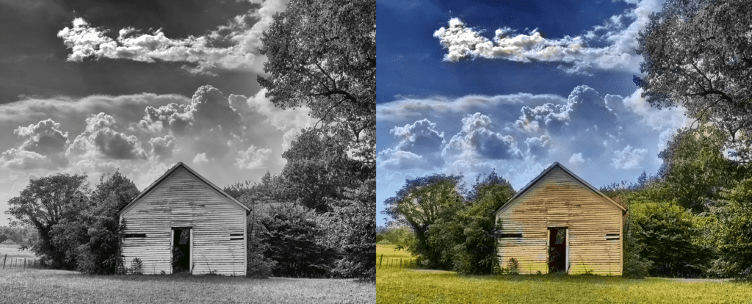



## Self-supervised Learning

According to [Wikipedia](https://en.wikipedia.org/wiki/Self-supervised_learning#:~:text=Self%2Dsupervised%20learning%20(SSL),help%20with%20downstream%20learning%20tasks): "Self-supervised learning (SSL) refers to a machine learning paradigm, and corresponding methods, for processing unlabeled data to obtain useful representations that can help with downstream learning tasks."

For a brief introduction on SSL see: https://youtu.be/bfCs3wqRSQY

The usual pipeline of an SSL application is:

1.   pre train a neural network on a pretext task (e.g. rotation, colorization, inpainting, etc)
2.   transfer the weights of the pre trained network to the final downstream task (e.g. classification)



## Image Colorization as the SSL Pretext/Proxy Task

The goal of this project is to use image colorization as the pretext task for a classification downstream task.

For an example of such a pipeline see: https://openaccess.thecvf.com/content_cvpr_2017/papers/Larsson_Colorization_as_a_CVPR_2017_paper.pdf

Therefore, this project entails:

1. Baseline - training a ResNet18 model (**from scratch**, i.e. without ImageNet pretraining) on the CIFAR10 dataset
2. Colorization - training an image colorization model
3. Using (part of) the model learned in 2. to initialize the weights of another ResNet18 model and finetuning it on the CIFAR10 dataset
4. Compare the **test set** accuracy of both models (1. and 3.)



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
from torchvision import datasets, models, transforms
import cv2
import shutil
from tqdm import tqdm
import random
random.seed(42) # DO NOT CHANGE THIS
torch.manual_seed(42) # DO NOT CHANGE THIS
from skimage.color import rgb2lab, lab2rgb, rgb2gray
import copy


# add more imports here


## Exercise 1

Train a ResNet18 model (**from scratch, i.e. without ImageNet pretraining!!**) on the CIFAR10 dataset.

Evaluate the obtained model on the **test set** in terms of accuracy.

In [2]:
# Some hyperparameters have already been defined. Feel free to experiment and change them as you see fit.
batch_size = 32
num_workers = 2
epochs = 5
learning_rate = 1e-3

In [3]:
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset = datasets.CIFAR10(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='dataset', train=False, transform=transforms.ToTensor())
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])
len(train_dataset), len(val_dataset), len(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:05<00:00, 29655432.66it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset


In [4]:
model1 = resnet18(pretrained=False, num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = optim.SGD(model1.parameters(), lr=learning_rate) #como alternativa ao Adam

#Training
def train(model1, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    epoch_acc= 0
    epoch_loss= 0

    for epoch in range(epochs):
        train_loss = 0.0
        train_acc=0
        val_loss=0
        val_acc=0

        model1.train()
        for image, labels in train_dataloader:
            image, labels = image.to(device), labels.to(device)
            optimizer.zero_grad() #clear the gradients
            outputs = model1(image) #forward pass
            loss = criterion(outputs, labels)
            loss.backward() #calculates gradients
            optimizer.step() #updates weights
            train_loss += loss.item() * image.size(0)

            #For each image:
            y_pred_tr_class = torch.argmax(outputs, dim=1)
            train_acc += (y_pred_tr_class == labels).sum().item() / len(labels)

        #Validation
        model1.eval()
        for image, labels in val_dataloader:
              image, labels = image.to(device), labels.to(device)
              outputs = model1(image)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * image.size(0)
              _, y_pred_val_class = torch.max(outputs, dim=1)
              val_acc += (y_pred_val_class == labels).sum().item()

              #print("y_pred val: ", type(y_pred_val_class))
              #print("labels val: ", labels.shape)


        print(f'Epoch {epoch+1}/{epochs} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {val_loss / len(val_dataloader)} \t\t Validation Accuracy: {val_acc / len(val_dataloader)}')

#Train the model
train(model1, criterion, optimizer, train_dataloader, val_dataloader, epochs)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5 		 Training Loss: 59.241819206839686 		 Validation Loss: 52.19959729188567 		 Validation Accuracy: 13.063694267515924
Epoch 2/5 		 Training Loss: 48.634009673736074 		 Validation Loss: 47.69546340529327 		 Validation Accuracy: 14.847133757961783
Epoch 3/5 		 Training Loss: 44.129630298248486 		 Validation Loss: 47.08983329602867 		 Validation Accuracy: 14.97452229299363
Epoch 4/5 		 Training Loss: 40.81818164860685 		 Validation Loss: 42.93099171340845 		 Validation Accuracy: 16.630573248407643
Epoch 5/5 		 Training Loss: 37.935376691581006 		 Validation Loss: 46.852238837321096 		 Validation Accuracy: 15.45859872611465


In [5]:
#Evaluate the model on the test set in terms of accuracy
model1.eval()
test_loss=0
test_acc= 0

with torch.no_grad():
      for image, labels in test_dataloader:
            image, labels = image.to(device), labels.to(device)
            outputs = model1(image)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * image.size(0)
            _, y_pred_test_class = torch.max(outputs, dim=1)
            test_acc += (y_pred_test_class == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
avg_test_acc = test_acc / len(test_dataloader)

print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')


Test Loss: 45.5716, Test Accuracy: 16.0415


## Exercise 2

Train an image colorization network on the CIFAR10 dataset.

We will be using the network proposed in https://lukemelas.github.io/image-colorization.html and depicted below.

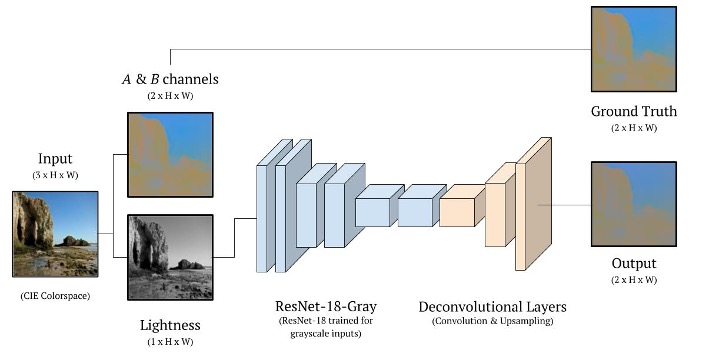

The network takes as input the grayscale version of an image and predicts its A and B channels (of the LAB color space).

The encoder part of the network is made of some layers of the ResNet18 architecture, but adapted to take grayscale inputs. See the implementation below for more details.

In [6]:
#defines NN model:
#1st: uses pre-trained ResNet for feature extraction
#2nd: upsampling network to generate colorized output

class ColorizationNet(nn.Module):
  def __init__(self, input_size=32):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(weights=None)
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )


  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

The torchvision CIFAR10 dataset also needs to be adapted to the colorization problem. Below you can find part of the code to do this. It builds upon the torchvision dataset. Introduce the necessary adaptations for the colorization problem.

In [7]:
class ColorizationDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # get the RGB image from torchvision's CIFAR10 dataset, convert it back from tensor to a numpy array
        input_tensor = self.base_dataset[idx][0]
        img_rgb = input_tensor.permute((1, 2, 0))
        img_rgb = img_rgb.numpy()
        #print("Rgb shape: ", img_rgb.shape) #(32, 32, 3)

        # convert the RGB image to LAB- by default, colour channel is the last
        img_lab = rgb2lab(img_rgb).astype(np.float32)
        img_ab = img_lab[:, :, 1:]  # AB channel
        #print("ab shape: ", img_ab.shape) # (32, 32, 2)

        #normalize AB channels to range [-1, 1]
        img_ab = (img_ab + 128) / 255.0 * 2 - 1

        # Convert to torch tensors
        img_ab = torch.from_numpy(img_ab).permute((2, 0, 1))  # Change to (2, H, W)
        #print("ab shape2: ", img_ab.shape) # (2, 32, 32)

        #convert to grayscale
        img_gray = rgb2gray(img_rgb)  # 1 channel (grayscale)
        img_gray= img_gray/100
        img_gray = torch.from_numpy(img_gray).unsqueeze(0)  # adds 1 dimension at the beginning: becomes (1, H, W)

        return img_gray, img_ab, img_rgb


In [8]:
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset_colour = ColorizationDataset(train_dataset)
val_dataset_colour = ColorizationDataset(val_dataset)
test_dataset_colour = ColorizationDataset(test_dataset)

train_dataloader_colour = DataLoader(train_dataset_colour, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_colour = DataLoader(val_dataset_colour, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_colour = DataLoader(test_dataset_colour, batch_size=batch_size, shuffle=False, num_workers=num_workers)




Train the network and evaluate its performance on the **test set** in terms of Mean Squared Error.

Plot some examples of the obtained results, comparing the input and ground-truth with the obtained colorized image.

Don't forget to transform the output of the network back into RGB.

In [9]:
#Train the model
model2 = ColorizationNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate) #como alternativa ao Adam

#Training
def train(model2, criterion, optimizer, train_dataloader_colour, val_dataloader_colour, epochs):

    for epoch in range(epochs):
        model2.train()
        train_loss = 0.0

        for img_gray, img_ab, _ in train_dataloader_colour:
            img_gray, img_ab = img_gray.to(device), img_ab.to(device)
            optimizer.zero_grad() #clear the gradients
            outputs = model2(img_gray) #forward pass
            loss = criterion(outputs, img_ab)
            loss.backward() #calculates gradients
            optimizer.step() #updates weights
            train_loss += loss.item() * image.size(0)

            avg_train_loss = train_loss / len(train_dataloader_colour)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

#Train the model
train(model2, criterion, optimizer, train_dataloader_colour, val_dataloader_colour, epochs)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/5, Training Loss: 0.7602
Epoch 2/5, Training Loss: 0.3091
Epoch 3/5, Training Loss: 0.2413
Epoch 4/5, Training Loss: 0.2176
Epoch 5/5, Training Loss: 0.2058


In [10]:
#Test the Model
model2.eval()
test_loss=0
test_acc= 0

with torch.no_grad():
        for img_gray, img_ab, _ in test_dataloader_colour:
            img_gray, img_ab = img_gray.to(device), img_ab.to(device)
            outputs = model2(img_gray)
            loss = criterion(outputs, img_ab)
            test_loss += loss.item() * image.size(0)

avg_test_loss = test_loss / len(test_dataloader_colour)
print(f'Test Loss: {avg_test_loss:.4f}')


Test Loss: 0.2061


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)


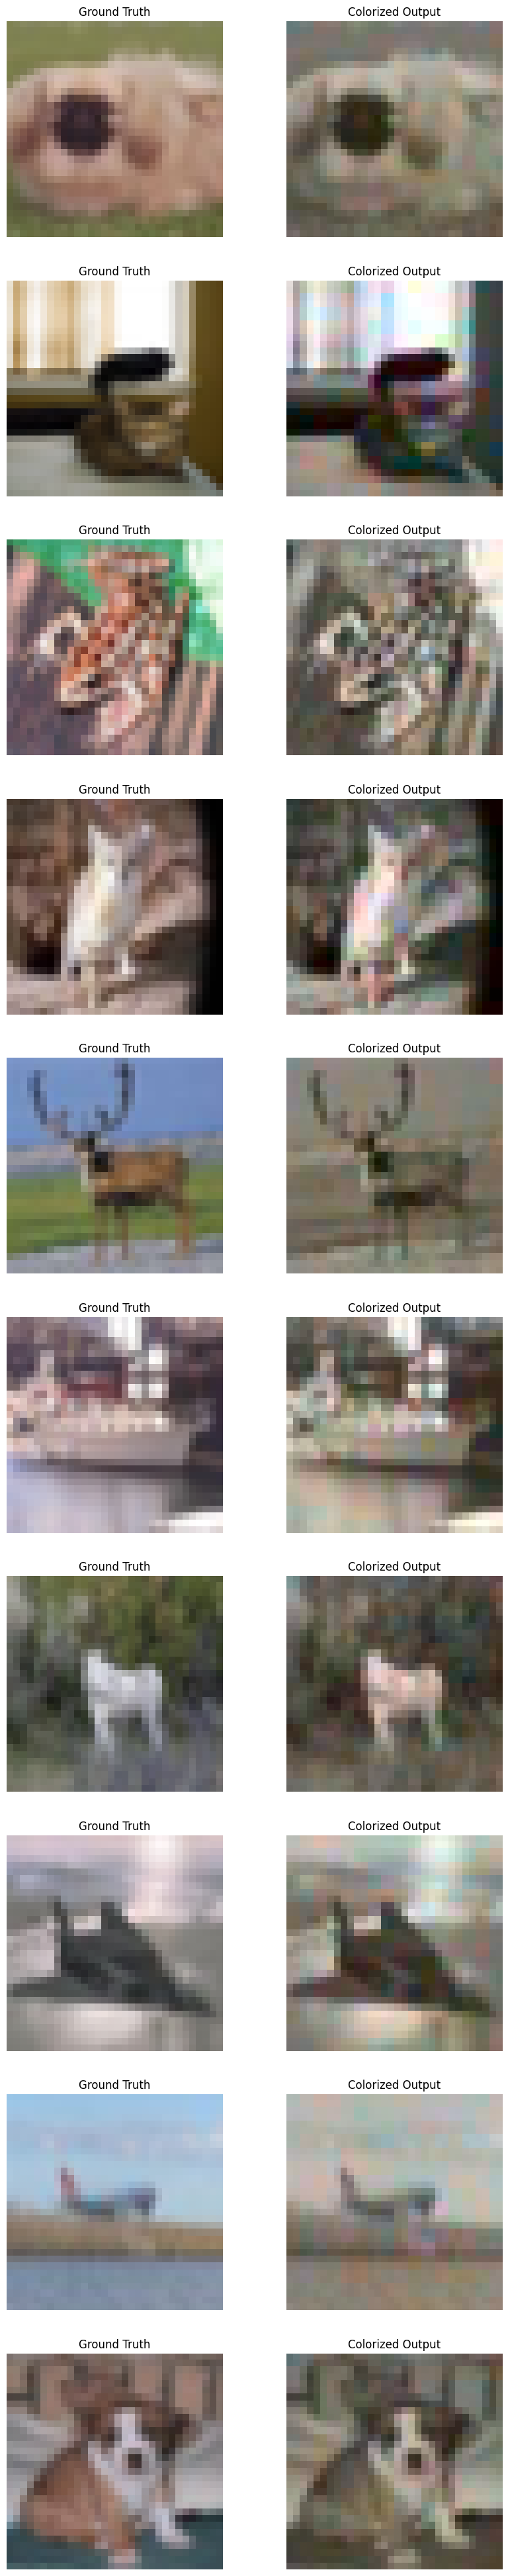

In [11]:
def plot_results(model2, test_dataloader_colour, num_examples=10):
    model2.eval()
    fig, axs = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))

    with torch.no_grad():
        for i, (img_gray, img_ab, img_rgb) in enumerate(test_dataloader_colour):
            if i >= num_examples:
                break
            img_gray, img_ab = img_gray.to(device), img_ab.to(device)
            outputs = model2(img_gray)

            # Transform the output to RGB
            outputs = outputs.cpu().numpy()
            img_gray = img_gray.cpu().numpy()
            img_ab = img_ab.cpu().numpy()
            img_rgb = img_rgb.cpu().numpy()

            for j in range(outputs.shape[0]):
                color_image = np.concatenate((img_gray[j, 0, :, :][:, :, np.newaxis] * 100, (outputs[j].transpose((1, 2, 0)) + 1) / 2 * 255 - 128), axis=-1)
                color_image = lab2rgb(color_image)

                axs[i, 0].imshow(img_rgb[j])
                axs[i, 1].imshow(color_image)

                axs[i, 0].set_title('Ground Truth')
                axs[i, 1].set_title('Colorized Output')

                axs[i, 0].axis('off')
                axs[i, 1].axis('off')

    plt.show()

# Plot the results
plot_results(model2, test_dataloader_colour)


## Exercise 3

Retrain a new ResNet18, but now transfer the weights learned from the ColorizationNet.

You need to take into account some aspects:
*   The input of the ColorizationNet only accepts 1 channel (grayscale image), so it needs to be reconverted into a 3 channel image. As the authors of the "Colorization as a Proxy Task for Visual Understanding" paper state: "When colorization is re-introduced, we convert the grayscale filters in conv1_1 to RGB (replicate to all three channels, divide by three) and let them fine-tune on the downstream task.".
*   The ColorizationNet does not use all layers of the ResNet18 architecture, so you can only transfer the weights of the layers that both have in common.
*  Don't forget that only certain layers have learnable weights (e.g. pooling/ReLU layers are not learned), so, naturally, only those can be transfered.



In [12]:
# Define the new ResNet18 model
class CustomResNet18(nn.Module):
    def __init__(self, pretrained=False, num_classes=10):
        super(CustomResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# transfer the weights from ColorizationNet to ResNet18
def transfer_weights(colorization_model, resnet_model):
    colorization_layers = list(colorization_model.midlevel_resnet.children())
    resnet_layers = list(resnet_model.resnet.children())

    # Transfer weights for common layers
    with torch.no_grad():
        colorization_index = 0
        for resnet_layer in resnet_layers[0:6]:  # Transfer weights only for layers shared with ColorizationNet
            if isinstance(resnet_layer, nn.Conv2d):
                # Special handling for the first convolutional layer
                if colorization_index == 0:
                    resnet_layer.weight.data = colorization_layers[colorization_index].weight.data.repeat(1, 3, 1, 1) / 3
                else:
                    resnet_layer.weight.data = colorization_layers[colorization_index].weight.data
                if hasattr(colorization_layers[colorization_index], 'bias'):
                  a=1
                  #print("Yes")
                #resnet_layer.bias.data = colorization_layers[colorization_index].bias.data
                colorization_index += 1

# Initialize the new ResNet18 model
resnet_model = CustomResNet18(pretrained=False, num_classes=10)

# Transfer the weights
transfer_weights(model2, resnet_model)

# train ResNet18 on the CIFAR10 dataset
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=learning_rate)

def train_resnet(model, criterion, optimizer, train_dataloader, val_dataloader, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

        epoch_loss = train_loss / len(train_dataloader.dataset)
        epoch_acc = train_acc.double() / len(train_dataloader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_dataloader.dataset)
        epoch_val_acc = val_acc.double() / len(val_dataloader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')


train_resnet(resnet_model, criterion, optimizer, train_dataloader, val_dataloader, epochs)


Epoch 1/5, Training Loss: 1.8701, Training Accuracy: 0.3210
Epoch 1/5, Validation Loss: 1.6224, Validation Accuracy: 0.4114
Epoch 2/5, Training Loss: 1.5344, Training Accuracy: 0.4430
Epoch 2/5, Validation Loss: 1.5792, Validation Accuracy: 0.4386
Epoch 3/5, Training Loss: 1.3981, Training Accuracy: 0.4961
Epoch 3/5, Validation Loss: 1.3982, Validation Accuracy: 0.5038
Epoch 4/5, Training Loss: 1.2878, Training Accuracy: 0.5383
Epoch 4/5, Validation Loss: 1.3587, Validation Accuracy: 0.5276
Epoch 5/5, Training Loss: 1.1931, Training Accuracy: 0.5738
Epoch 5/5, Validation Loss: 1.3994, Validation Accuracy: 0.5094


Evaluate the obtained model on the **test set** in terms of accuracy.

Compare the performance of both models: ResNet18 trained from scratch vs ResNet18 finetuned after colorization.

In [13]:
#Test the new model in accuracy
resnet_model.eval()
test_loss=0
test_acc= 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
        for image, labels in test_dataloader:
            image, labels = image.to(device), labels.to(device)
            outputs = resnet_model(image)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * image.size(0)

            #For each image:
            y_pred_test_class = torch.argmax(outputs, dim=1)
            test_acc += (y_pred_test_class == labels).sum().item() / len(labels)

avg_test_loss = test_loss / len(test_dataloader)
avg_test_acc = test_acc / len(test_dataloader)

print(f'ResNet finetuned - Test Loss: {avg_test_loss:.4f} \t\t Test Accuracy: {avg_test_acc:.4f} ')


#Evaluate the old model in terms of accuracy
model1.eval()
test_loss=0
test_acc= 0

with torch.no_grad():
      for image, labels in test_dataloader:
            image, labels = image.to(device), labels.to(device)
            outputs = model1(image)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * image.size(0)
            _, y_pred_test_class = torch.max(outputs, dim=1)
            test_acc += (y_pred_test_class == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
avg_test_acc = test_acc / len(test_dataloader)

print(f'ResNet from scratch - Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')


ResNet finetuned - Test Loss: 44.5090 		 Test Accuracy: 0.5027 
ResNet from scratch - Test Loss: 45.5716, Test Accuracy: 16.0415


**Comparing  the performance of both models**, we expect the ResNet18 finetuned after colorization to perform better than the ResNet18 trained from scratch.

By fine-tuning the model with the colourization task, it is taking the knowledge learned from that task and applying into the new task. More precisely, it is starting out with weights that have already been sort of optimized for the features of the new task.
A model trained from scratch starts with randomly initialized weights and learns specific features by using only the dataset.
Because of this, the fine-tuned model should have a better performance.


In reality, it appears that test accuracy was better on the ResNet trained from scratch. However, it is likely that there was an error while computing the accuracies given that they have very distinct values.

